# Population Simulator

In [30]:
import random
from matplotlib import pyplot as plt

In [2]:
class Individual(object):
    """This class represents an individual."""

    def __init__(self, gamete1, gamete2):
        """
        @param genes1: sequence of alleles on first "chromosome".
        Each allele is a symbol; typically an integer or a random string.
        @param genes2: sequence of alleles on second "chronosome". """
        self.chromosomes = list(zip(gamete1, gamete2))

    @staticmethod
    def create_random(num_genes=1, num_alleles=2):
        gamete1, gamete2 = [[random.randint(0, num_alleles - 1) for _ in range(num_genes)] for g in range(2)]
        return Individual(gamete1, gamete2)

    def gamete(self):
        """Returns random gamete."""
        return [a[random.randint(0, 1)] for a in self.chromosomes]

    def __eq__(self, other):
        """Checks for genetic equality."""
        return self.chromosomes == other.chromosomes

    def __repr__(self):
        return str(self.chromosomes)


In [3]:
# chromosomes: [('A', 'a'), ('B', 'b')]
# Alleles: A, a, B, b
i = Individual(['A', 'B'], ['a', 'b'])
i.chromosomes


[('A', 'a'), ('B', 'b')]

In [22]:
from collections import defaultdict
class Population(object):
    """This class represents the snapshot of a population."""

    def __init__(self, individuals=None):
        self.individuals = individuals or []
        self.females, self.males = None, None
        self.gene_frequencies = []

    def __len__(self):
        return len(self.individuals)

    def __iter__(self):
        return iter(self.individuals)

    def add(self, individual):
        self.individuals.append(individual)

    def pick_individual(self):
        """Returns a random individual."""
        return random.choice(self.individuals)

    def random_mating(self):
        """Returns an individual produced via random mating."""
        g1 = self.pick_individual().gamete()
        g2 = self.pick_individual().gamete()
        return Individual(g1, g2)

    def random_hermaphrodite_mating(self):
        """Returns an individual generated via non-self mating,
        aka Banana Slug mating."""
        i1, i2 = random.sample(self.individuals, k=2)
        g1 = i1.gamete()
        g2 = i2.gamete()
        return Individual(g1, g2)

    def partition_genders_randomly(self, prob=0.5):
        """Partition the population in genders, randomly.
        Returns whether there is at least somebody of both genders."""
        self.males, self.females = [], []
        for x in self.individuals:
            if random.random() < prob:
                self.females.append(x)
            else:
                self.males.append(x)
        return len(self.females) > 0 and len(self.males) > 0

    def random_sexual_mating(self, prob=0.5):
        """This is a simple model, in which mating can happen only between
        individuals of opposite sex, and we are given the probability that an
        individual is of a given sex.
        We could do things in another way, but this is ok for now."""
        if self.females is None and self.males is None:
            feasible = self.partition_genders_randomly(prob=prob)
            if not feasible:
                return None
        f = random.choice(self.females)
        m = random.choice(self.males)
        return Individual(f.gamete(), m.gamete())

    def get_generation(self, method, *args, **kwargs):
        """Gets a new generation according to the given method."""
        new_pop = Population()
        for _ in range(len(self.individuals)):
            new_pop.add(method(self, *args, **kwargs))
        return new_pop


    def __repr__(self):
        """You can improve this..."""
        return "\n".join([str(i) for i in self.individuals])

    '''
    Calculates the frequency of each gene (combonation of alleles) in the current generation
    gene_frequencies is list of lists of [freq of AA, freq of Aa, freq of aa] for each generation
    '''
    def update_gene_frequencies(self):
        allele_freq = {'[1, 1]': 0, '[0, 1]': 0, '[0, 0]': 0}
        # allele_freq = defaultdict(lambda:0)
        total_alleles = 0

        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                allele_freq[sorted_chromosome] += 1

                # if sorted_chromosome not in allele_freq:
                #     allele_freq[sorted_chromosome] = 1
                # else:
                #     allele_freq[sorted_chromosome] += 1

                
                total_alleles += 1
        
        prob_of_genes = {}
        for allele, freq in allele_freq.items():
            prob_of_genes[allele] = freq / total_alleles

        self.gene_frequencies.append(list(prob_of_genes.values()))
        # return list(prob_of_genes.values())

    '''
    Caluclates prob of each allele at last generation of gene_frequencies
    gene_frequencies is list of lists of [freq of 11, freq of 01, freq of 00] for each generation
    '''
    def get_p_and_q(self):
        if len(self.gene_frequencies) < 2:
            return 0
        freq_of_genes = self.gene_frequencies[-2]
        N = len(self.individuals)

        # prob of A = (2(AA freq)N + (Aa freq)N) / 2N
        p_A = (2 * freq_of_genes[0] * N + freq_of_genes[1]*N) / (2*N)
        # prob of a = (2N * (aa freq) + N * (Aa freq)) / 2N
        p_a = (2 * freq_of_genes[2] * N + freq_of_genes[1]*N) / (2*N)

        return (p_A, p_a)
            
    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in gene_frequencies
    '''
    def calculate_true_F(self):
        if len(self.gene_frequencies) < 2:
            return 0

        freq_of_genes_last_gen = self.gene_frequencies[-1]
        p_0, p_1 = self.get_p_and_q()

        F = ((2*p_1*p_0) - freq_of_genes_last_gen[1]) / (2*p_1*p_0) if p_1*p_0 != 0 else 0
        return F

    '''
    p = frequency of allele A
    q = frequency of allele a
    H_o = 2pq = normal heterozygot frequency
    H = observed heterozygot frequency
    F = (H_o - H) / H_o
    compute heterozygocity and homozygocity, compare to harvey weindberg
    '''
    def calculate_expected_F(self, gene_frequencies):
        # homozygote_prob = 0
        # for allele, prob in prob_of_genes:
        #     if allele[0] == allele[1]:
        #         homozygote_prob += prob

        # return homozygote_prob
        pass

    # f_t0 = 0
    def get_estimated_fst(self):
        # aa_freq, Aa_freq, AA_freq = self.full_fraction_list[-1]
        N = len(self.individuals)
        # p_1 = (2 * aa_freq * N + Aa_freq*N) / (2*N)
        # p_0 = (2 * AA_freq * N + Aa_freq*N) / (2*N)
        # Fst = sigma**2 / (p1 * p2)

        # return 0.5 * N * (1-(0.5 * N)) * (self.get_f(t-1))

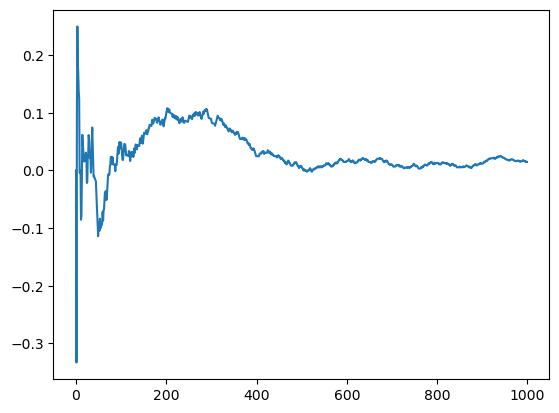

In [32]:
# Let's simulate 100 generations.
pop = Population()
f_ls = []
for j in range(1000):
    i = Individual.create_random(num_genes=2)
    pop.add(i)
    pop.update_gene_frequencies()
    F = pop.calculate_true_F()
    # print(F)
    f_ls.append(F)

plt.plot(f_ls)
plt.show()

Now random mating

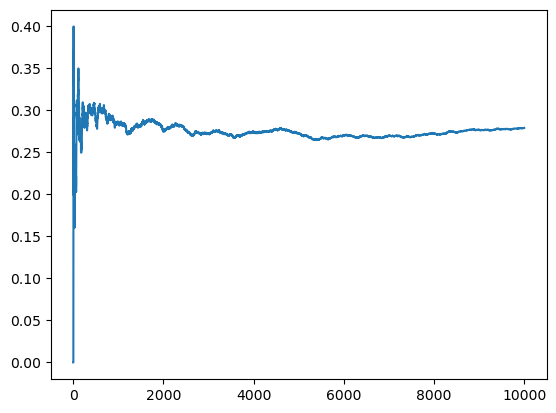

In [45]:
# Random Mating

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)

pop = Population([ind_1,ind_2])
random_mating_f_ls = []

for j in range(10000):
    # print(f'Generation {j}')
    i = pop.random_mating()
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'pop.gene_frequencies[-1]: {pop.gene_frequencies[-1]}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    random_mating_f_ls.append(F)

    # print(pop)

plt.plot(random_mating_f_ls)
plt.show()

Random sexual mating w/ gender ratio 0.5

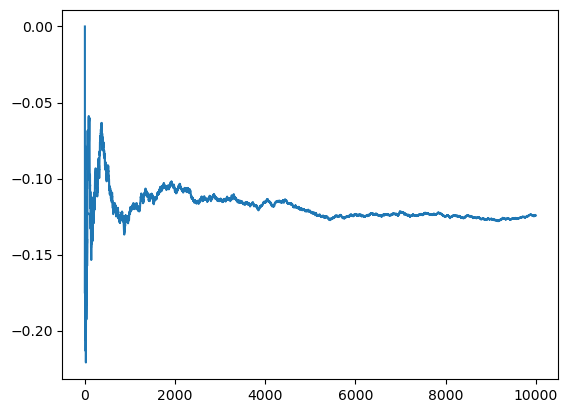

In [46]:
# Random sexual mating w/ 0.5

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
ind_3 = Individual.create_random(num_genes=2)
ind_4 = Individual.create_random(num_genes=2)
ind_5 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2,ind_3,ind_4,ind_5])
random_sexual_mating_f_ls = []
for j in range(10000):
    # print(f'Generation {j}')
    i = pop.random_sexual_mating(0.5)
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    random_sexual_mating_f_ls.append(F)

    # print(pop)

plt.plot(random_sexual_mating_f_ls)
plt.show()

Random sexual mating w/ gender ratio 0.9

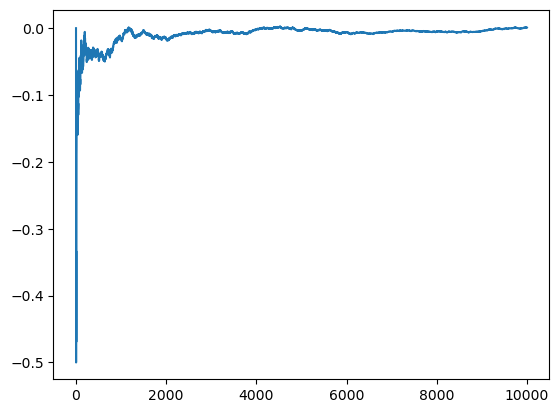

In [49]:
# Random sexual mating w/ gender ratio 0.9

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
ind_3 = Individual.create_random(num_genes=2)
ind_4 = Individual.create_random(num_genes=2)
ind_5 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2,ind_3,ind_4,ind_5])
random_sexual_mating_09_f_ls = []
for j in range(10000):
    # print(f'Generation {j}')
    i = pop.random_sexual_mating(0.9)
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    random_sexual_mating_09_f_ls.append(F)

    # print(pop)

plt.plot(random_sexual_mating_09_f_ls)
plt.show()

Random Hermaphrodite Mating

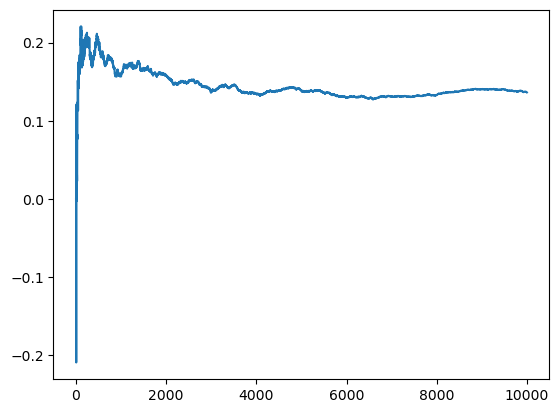

In [50]:
# random hermaphrodite mating

ind_1 = Individual.create_random(num_genes=2)
ind_2 = Individual.create_random(num_genes=2)
ind_3 = Individual.create_random(num_genes=2)
ind_4 = Individual.create_random(num_genes=2)
ind_5 = Individual.create_random(num_genes=2)
pop = Population([ind_1,ind_2,ind_3,ind_4,ind_5])
random_hermaphrodite_mating_f_ls = []
for j in range(10000):
    # print(f'Generation {j}')
    i = pop.random_hermaphrodite_mating()
    pop.add(i)
    pop.update_gene_frequencies()
    # print(f'fraction: {fraction}')
    F = pop.calculate_true_F()
    # print(f'F: {F}')
    random_hermaphrodite_mating_f_ls.append(F)

    # print(pop)

plt.plot(random_hermaphrodite_mating_f_ls)
plt.show()

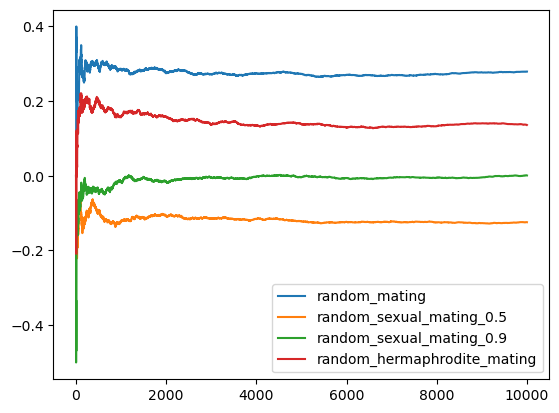

In [52]:
plt.plot(random_mating_f_ls, label='random_mating')
plt.plot(random_sexual_mating_f_ls, label='random_sexual_mating_0.5')
plt.plot(random_sexual_mating_09_f_ls, label='random_sexual_mating_0.9')
plt.plot(random_hermaphrodite_mating_f_ls, label='random_hermaphrodite_mating')
plt.legend() 
plt.show()